## Import lib.

In [1]:
import os
import zipfile

import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm



from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import numpy as np 


## Import data

In [2]:
with open(".env") as f:
    for line in f:
        key, val = line.strip().split("=")
        os.environ[key] = val

# print("Kaggle user:", os.environ['KAGGLE_USERNAME'])  
# print("Kaggle user:", os.environ['KAGGLE_KEY'])  

In [3]:
# !kaggle datasets download -d fantacher/neu-metal-surface-defects-data

In [4]:
# with zipfile.ZipFile("neu-metal-surface-defects-data.zip", "r") as zip_ref:
#     zip_ref.extractall("neu_defects")

In [3]:
base_path = r"D:\Metal_surface_defect\neu_defects\NEU Metal Surface Defects Data"
splits = ["train", "test", "valid"]
classes = ["Crazing", "Inclusion", "Patches", "Pitted", "Rolled", "Scratches"]


In [4]:
def get_all_images(base_path, split, classes):
    images = []
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        images += [os.path.join(folder, img) for img in os.listdir(folder)]
    return images

train_images = get_all_images(base_path, "train", classes)
test_images = get_all_images(base_path, "test", classes)
val_images = get_all_images(base_path, "valid", classes)

print(f"Train images count: {len(train_images)}")
print(f"Test images count: {len(test_images)}")
print(f"Validation images count: {len(val_images)}")

Train images count: 1656
Test images count: 72
Validation images count: 72


## Image Processing 

In [208]:
img = cv2.imread(train_images[276]) #0 - 275 change type

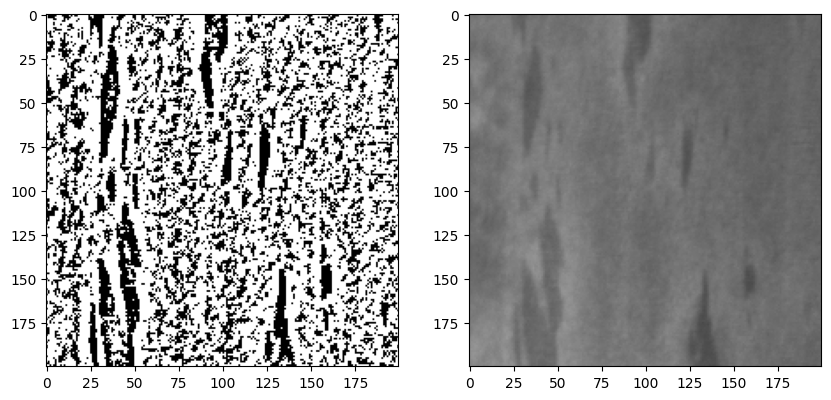

In [209]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
adaptive = cv2.adaptiveThreshold(
    gray,                    # input image (must be 8-bit grayscale)
    255,                        # max value to use with THRESH_BINARY
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # adaptive method (or cv2.ADAPTIVE_THRESH_MEAN_C)
    cv2.THRESH_BINARY,          # threshold type
    15,                         # block size (must be odd)
    2                           # C: constant subtracted from mean/weighted mean
)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(adaptive,cmap='gray')
plt.subplot(122)
plt.imshow(img)

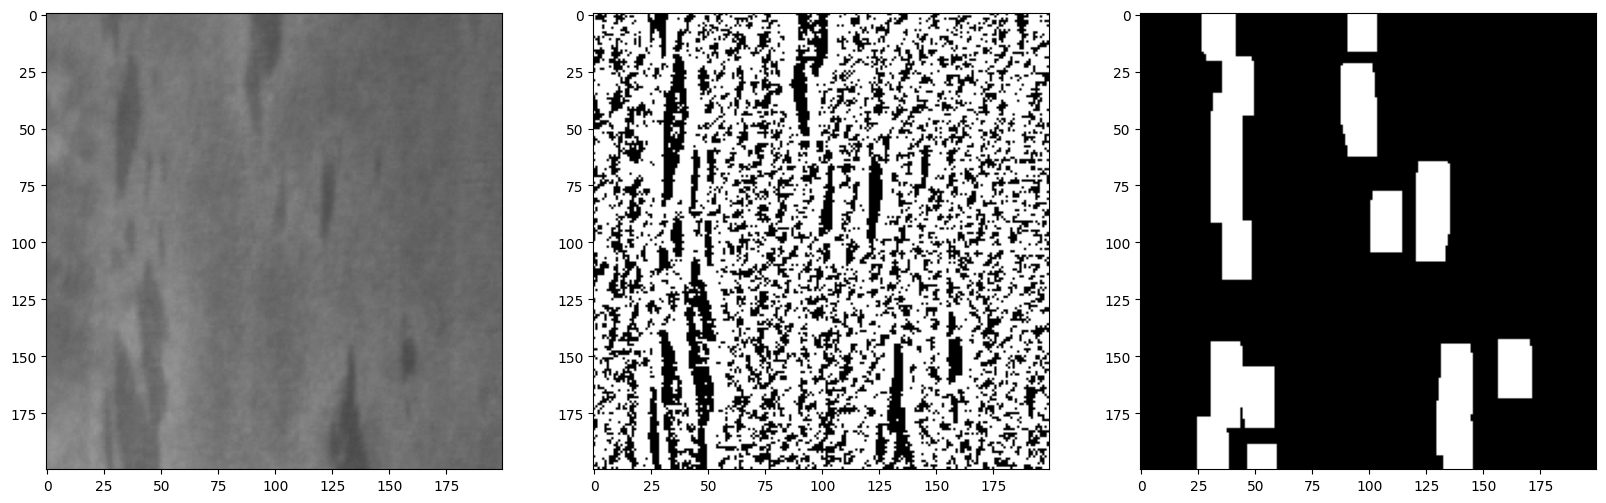

In [9]:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 13))
vertical_lines = cv2.morphologyEx(adaptive, cv2.MORPH_CLOSE, vertical_kernel, iterations=1)
inverted = cv2.bitwise_not(vertical_lines)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
dilation = cv2.dilate(inverted,kernel,iterations=10)

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(adaptive,cmap='gray')
plt.subplot(133)
plt.imshow(dilation,cmap='gray')

## Create labels

In [5]:
classes = ["Crazing", "Inclusion", "Patches", "Pitted", "Rolled", "Scratches"]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
class_to_idx

{'Crazing': 0,
 'Inclusion': 1,
 'Patches': 2,
 'Pitted': 3,
 'Rolled': 4,
 'Scratches': 5}

In [6]:
train_images[0]

'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_120.bmp'

In [7]:
def get_label(image_path):
    for cls in classes:
        if f"\\{cls}\\" in image_path or f"/{cls}/" in image_path:
            return class_to_idx[cls]
    raise ValueError(f"Class not found in path: {image_path}")

In [8]:
train_labels = [get_label(path) for path in train_images]
test_labels = [get_label(path) for path in test_images]
val_labels = [get_label(path) for path in val_images]

In [9]:
print(train_labels[0])
print(train_labels[276])
print(train_labels[552])

0
1
2


## Prepare data

In [10]:
set(train_labels) #number of classes.

{0, 1, 2, 3, 4, 5}

In [11]:
train_images[:5]

['D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_120.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_121.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_122.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_123.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_124.bmp']

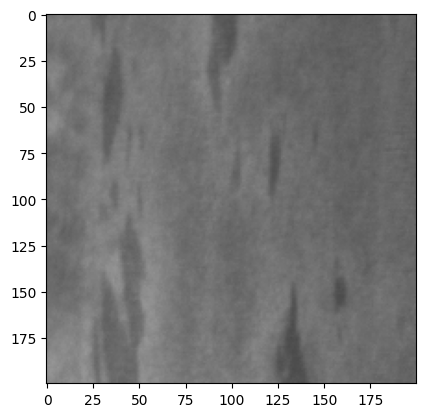

In [12]:
plt.imshow(cv2.imread(train_images[276])) #correct idx

## Data augmentation

In [102]:
base_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
])

aug_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.1171243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


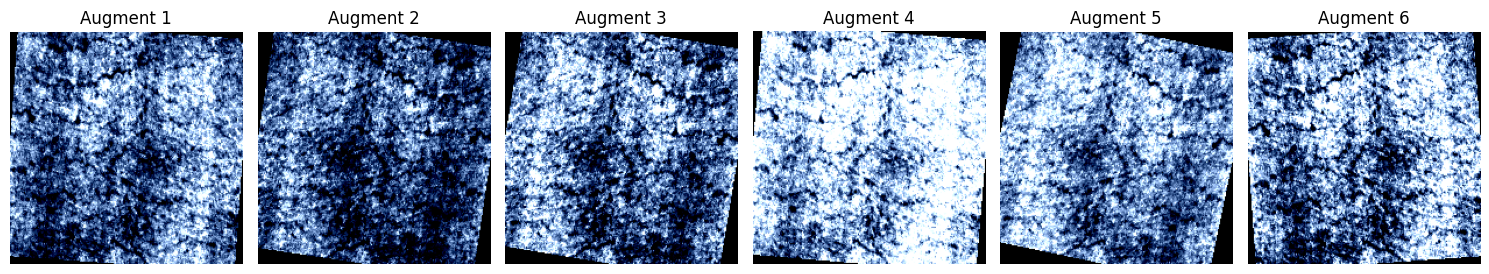

In [103]:
img = Image.open(train_images[0]).convert("RGB")

plt.figure(figsize=(15, 5))
for i in range(6):
    aug_img = aug_transform(img)
    plt.subplot(1, 6, i+1)
    plt.imshow(aug_img.permute(1, 2, 0))  # CHW -> HWC
    plt.axis("off")
    plt.title(f'Augment {i+1}')
plt.tight_layout()
plt.show()

## Dataloader

In [104]:
img = Image.open(train_images[0]).convert("RGB")
img.size

(200, 200)

In [105]:
class FlexibleDataset(Dataset):
    def __init__(self, X, y, base_transform=None, aug_transform=None, 
                 augmentation_ratio=1.0):

        self.x = X
        self.y = y
        self.base_transform = base_transform
        self.aug_transform = aug_transform
        self.augmentation_ratio = augmentation_ratio
        
        # Calculate lengths
        self.original_len = len(self.x)
        self.aug_samples = int(self.original_len * self.augmentation_ratio)
        self.total_len = self.original_len + self.aug_samples
        
        print(f'Original samples: {self.original_len}')
        print(f'Augmented samples: {self.aug_samples}')
        print(f'Total samples: {self.total_len}')
        print("-"*50)

    def __len__(self):
        return self.total_len #importance 

    def __getitem__(self, idx):
        if idx < self.original_len:
            # Original samples
            x = Image.open(self.x[idx]).convert("RGB")
            y = self.y[idx]
            if self.base_transform:
                x = self.base_transform(x)
            return x, y
        else:
            # Augmented samples
            aug_idx = idx % self.original_len
            x = Image.open(self.x[aug_idx]).convert("RGB")
            y = self.y[aug_idx]

            if self.aug_transform:
                x = self.aug_transform(x)
            elif self.base_transform: #prevent not input param.
                x = self.base_transform(x)
            return x, y


In [107]:
train_loader = DataLoader(FlexibleDataset(train_images,train_labels,base_transform=base_transform,aug_transform=aug_transform,augmentation_ratio=0),
                          batch_size=128,shuffle=True)
val_loader = DataLoader(FlexibleDataset(val_images,val_labels,base_transform=base_transform,aug_transform=aug_transform,augmentation_ratio=0),
                          batch_size=72,shuffle=False) #don't need True!!!! because Fair Comparison โมเดลไม่รุ้ดีขึ้นเพราะอะไร 
test_loader = DataLoader(FlexibleDataset(test_images,test_labels,base_transform=base_transform,aug_transform=aug_transform,augmentation_ratio=0),
                          batch_size=72,shuffle=False)


data, labels = next(iter(train_loader))
data.shape

Original samples: 1656
Augmented samples: 0
Total samples: 1656
--------------------------------------------------
Original samples: 72
Augmented samples: 0
Total samples: 72
--------------------------------------------------
Original samples: 72
Augmented samples: 0
Total samples: 72
--------------------------------------------------


torch.Size([128, 3, 200, 200])

## Training

In [108]:
output_size = len(set(train_labels))
output_size

6

In [111]:
class CNNClassifier(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=3,
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=3
        )
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(128 * 48 * 48, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.avgpool1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = self.avgpool2(x)
        x = torch.nn.functional.relu(x)
        x = self.flatten(x)
        x = self.fc_1(x)
        x = self.fc_2(x)
        x = self.fc_3(x)
        return x

In [113]:
model = CNNClassifier(output_size)
print(model)

CNNClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=294912, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=6, bias=True)
)


In [114]:
model = CNNClassifier(output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(),lr=learning_rate)

In [115]:
n_epoch = 10
train_loss_plot = []
val_loss_plot = []

for epoch in range(n_epoch):
    
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{n_epoch}]")
    for inputs , labels in train_loop:
        #setting
        inputs,labels = inputs.to(device) , labels.to(device)
        optim.zero_grad()

        #forward
        outputs = model(inputs)
        loss = criterion(outputs,labels)

        #backward 
        loss.backward()

        #update
        optim.step()

        #keep
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(labels).sum().item()
        train_total += labels.size(0)

        train_loop.set_postfix(loss=loss.item(), acc=100. * train_correct / train_total)

    epoch_loss = train_loss / len(train_loader)
    train_loss_plot.append(epoch_loss)
    epoch_acc = 100. * train_correct / train_total 


    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0 

    with torch.no_grad():
        # val_loop = tqdm(val_loader,desc='validation')
        for inputs,labels in val_loader:
            #setting 
            inputs,labels = inputs.to(device),labels.to(device)

            #forward 
            outputs = model(inputs)
            loss = criterion(outputs,labels)

            #keep 
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels).sum().item()
            val_total += labels.size(0)

            # val_loop.set_postfix(loss=loss.item(), acc=100. * val_correct / val_total)

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100. * val_correct / val_total
    val_loss_plot.append(epoch_val_loss)
    print(f"Epoch {epoch+1} | train_loss: {epoch_loss:.4f} | train_accuracy: {epoch_acc:.2f}% | val_loss: {epoch_val_loss:.4f} | val_accuracy: {epoch_val_acc:.2f}%")
    # print(f"Epoch {epoch+1} | train_loss: {epoch_loss:.4f}| val_loss: {epoch_val_loss:.4f}") #We don't should monitoring acc between train val
# monitor loss mini_batch train with val 

Epoch [1/10]: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it, acc=30.7, loss=1.62]


Epoch 1 | train_loss: 6.2565 | train_accuracy: 30.74% | val_loss: 1.5703 | val_accuracy: 38.89%


Epoch [2/10]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it, acc=40, loss=1.41]  


Epoch 2 | train_loss: 1.5074 | train_accuracy: 39.98% | val_loss: 1.3500 | val_accuracy: 45.83%


Epoch [3/10]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it, acc=56, loss=1.17]  


Epoch 3 | train_loss: 1.2199 | train_accuracy: 55.98% | val_loss: 1.1119 | val_accuracy: 56.94%


Epoch [4/10]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it, acc=65.6, loss=0.92] 


Epoch 4 | train_loss: 0.9473 | train_accuracy: 65.64% | val_loss: 0.7771 | val_accuracy: 72.22%


Epoch [5/10]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it, acc=76.1, loss=0.784]


Epoch 5 | train_loss: 0.7050 | train_accuracy: 76.15% | val_loss: 0.9556 | val_accuracy: 77.78%


Epoch [6/10]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it, acc=80.9, loss=0.578]


Epoch 6 | train_loss: 0.5824 | train_accuracy: 80.86% | val_loss: 0.5304 | val_accuracy: 83.33%


Epoch [7/10]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it, acc=85.7, loss=0.4]  


Epoch 7 | train_loss: 0.4353 | train_accuracy: 85.69% | val_loss: 0.3502 | val_accuracy: 87.50%


Epoch [8/10]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it, acc=88, loss=0.349]  


Epoch 8 | train_loss: 0.3943 | train_accuracy: 87.98% | val_loss: 0.3981 | val_accuracy: 86.11%


Epoch [9/10]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it, acc=87.4, loss=0.328]


Epoch 9 | train_loss: 0.3724 | train_accuracy: 87.38% | val_loss: 0.5020 | val_accuracy: 83.33%


Epoch [10/10]: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it, acc=88.9, loss=0.433]

Epoch 10 | train_loss: 0.3312 | train_accuracy: 88.89% | val_loss: 0.4257 | val_accuracy: 87.50%


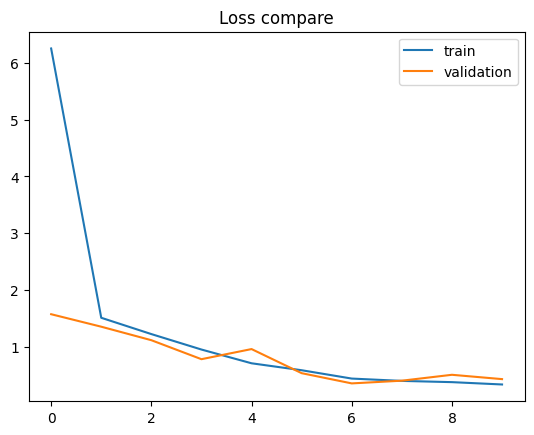

In [116]:
plt.title('Loss compare')
plt.plot(train_loss_plot,label='train')
plt.plot(val_loss_plot,label='validation')
plt.legend()
plt.show()

## Test 

In [117]:
model.eval()  # Set model to eval mode
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    test_loop = tqdm(test_loader, desc="Testing")
    for inputs, labels in test_loop:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_correct += predicted.eq(labels).sum().item()
        test_total += labels.size(0)

        acc = 100. * test_correct / test_total
        test_loop.set_postfix(loss=loss.item(), acc=acc)

final_test_loss = test_loss / len(test_loader)
final_test_acc = 100. * test_correct / test_total

print(f"Final Test Accuracy: {final_test_acc:.2f}% | Test Loss: {final_test_loss:.4f}")

Testing: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s, acc=83.3, loss=0.515]

Final Test Accuracy: 83.33% | Test Loss: 0.5147
